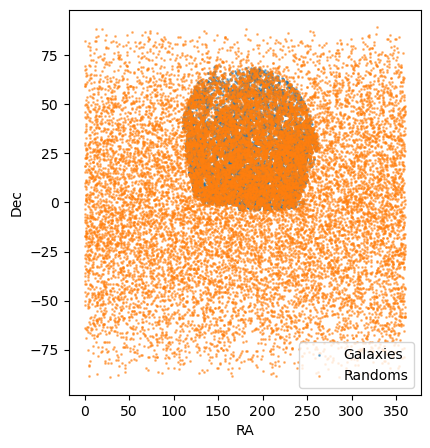

In [14]:
"""
Generar máscara de randoms a partir de RA/Dec de galaxias y luego suavizar
"""

import numpy as np
import healpy as hp
import pandas as pd
from typing import Tuple
import numpy.random as rng

def generate_random_radec(ra: np.ndarray, dec: np.ndarray, nside: int, num_randoms: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate nrand random RA/Dec pairs that fall on Healpix pixels marked by the input (ra,dec).
    Implementation preserved from original code.
    """
    npix = hp.nside2npix(nside)
    mask_ = np.zeros(npix, dtype=int)

    theta = np.radians(90.0 - dec)
    phi = np.radians(ra)
    pixels = hp.ang2pix(nside, theta, phi)

    mask_[pixels] = 1

    # Smooth
    smooth_angle = 1.0
    mask = hp.sphtfunc.smoothing(mask_, fwhm=np.deg2rad(smooth_angle))
    mask  = (mask - mask.min()) / (mask.max() - mask.min())

    u    = rng.uniform(-1,   1, size=num_randoms) 
    _RA  = rng.uniform( 0, 360, size=num_randoms) 
    _Dec = np.rad2deg(np.arcsin(u)) 

    random_pixels  = hp.ang2pix(nside, _RA, _Dec, lonlat=True) 
    my_random_mask = (mask[random_pixels] > 0)*(rng.random(len(random_pixels)) < mask[random_pixels])
    
    _RA  = _RA[my_random_mask]
    _Dec = _Dec[my_random_mask]

    # # Iterate until we have enough valid random points
    # ra_random = np.random.uniform(0.0, 360.0, num_randoms)
    # u = np.random.uniform(-1.0, 1.0, num_randoms)
    # dec_random_rad = np.arcsin(u)
    # dec_random = np.degrees(dec_random_rad)

    # theta_random = np.radians(90.0 - dec_random)
    # phi_random = np.radians(ra_random)
    # random_pixels = hp.ang2pix(nside, theta_random, phi_random)

    # valid_indices = mask[random_pixels] == 1
    # ra_random = ra_random[valid_indices]
    # dec_random = dec_random[valid_indices]

    # while ra_random.shape[0] < num_randoms:
    #     additional_needed = num_randoms - ra_random.shape[0]
    #     ra_additional = np.random.uniform(0.0, 360.0, additional_needed * 2)
    #     u_additional = np.random.uniform(-1.0, 1.0, additional_needed * 2)
    #     dec_additional_rad = np.arcsin(u_additional)
    #     dec_additional = np.degrees(dec_additional_rad)

    #     theta_additional = np.radians(90.0 - dec_additional)
    #     phi_additional = np.radians(ra_additional)
    #     additional_pixels = hp.ang2pix(nside, theta_additional, phi_additional)

    #     valid_additional_indices = mask[additional_pixels] == 1
    #     ra_valid = ra_additional[valid_additional_indices]
    #     dec_valid = dec_additional[valid_additional_indices]

    #     ra_random = np.concatenate((ra_random, ra_valid))
    #     dec_random = np.concatenate((dec_random, dec_valid))

    # if ra_random.shape[0] < num_randoms:
    #     raise ValueError("Not enough random points generated. Increase num_randoms or adjust nside.")

    return _RA, _Dec

def load_catalog(sample_name: str) -> pd.DataFrame:
    """Load the requested SDSS-like catalog (logic preserved)."""
    if sample_name == "nyu":
        datafile = "../data/sdss_dr72safe0_zmin_0.000_zmax_0.300_sigma_5.0.csv"
    elif sample_name == "sdss":
        datafile = "../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv"
    else:
        raise ValueError("Invalid sample")

    cat = pd.read_csv(datafile)
    cat["dist_fil"] /= h
    if gr_min != 0:
        cat = cat[cat["gr"] > gr_min]
    return cat

def select_sample(cat: pd.DataFrame) -> pd.DataFrame:
    """Apply redshift and magnitude cuts (preserves original behavior)."""
    cat_z = cat[(cat["red"] >= zmin) & (cat["red"] <= zmax)]
    if sample == "nyu":
        cat_z_mag = cat_z[cat_z["mag_abs_r"] < mag_max].copy()  # <-- add .copy()
    else:
        cat_z_mag = cat_z[cat_z["mag_abs_r"] - 5 * np.log10(h) < mag_max].copy()  # <-- add .copy()
    return cat_z, cat_z_mag

# ---- Sample----------
sample = 'nyu'
h = 0.6774  # Hubble constant
#zmin, zmax = 0.07, 0.12  # Redshift range
zmin, zmax = 0.07, 0.11  # Redshift range
mag_max = -21.
ran_method = 'poly'  # ['random_choice', 'piecewise', 'poly']
if ran_method == 'poly':
    deg = 5  # degree of polynomial for redshift distribution fit 
if zmax == 0.12: 
    mag_max = -20.0  # Maximum magnitude
elif zmax == 0.2:
    mag_max = -21.2  # Maximum magnitude
gr_min = 0.8
#dist_min = 5.0
#dist_max = 10.0

cat_full = load_catalog(sample)
cat_z, cat_z_mag = select_sample(cat_full)

randoms = generate_random_radec(cat_z_mag["ra"].values, cat_z_mag["dec"].values, nside=64, num_randoms=100000)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(cat_z_mag["ra"], cat_z_mag["dec"], s=1, alpha=0.5, label="Galaxies")
plt.scatter(randoms[0], randoms[1], s=1, alpha=0.5, label="Randoms")
plt.xlabel("RA")
plt.ylabel("Dec")
plt.legend()

N galaxies = 23138


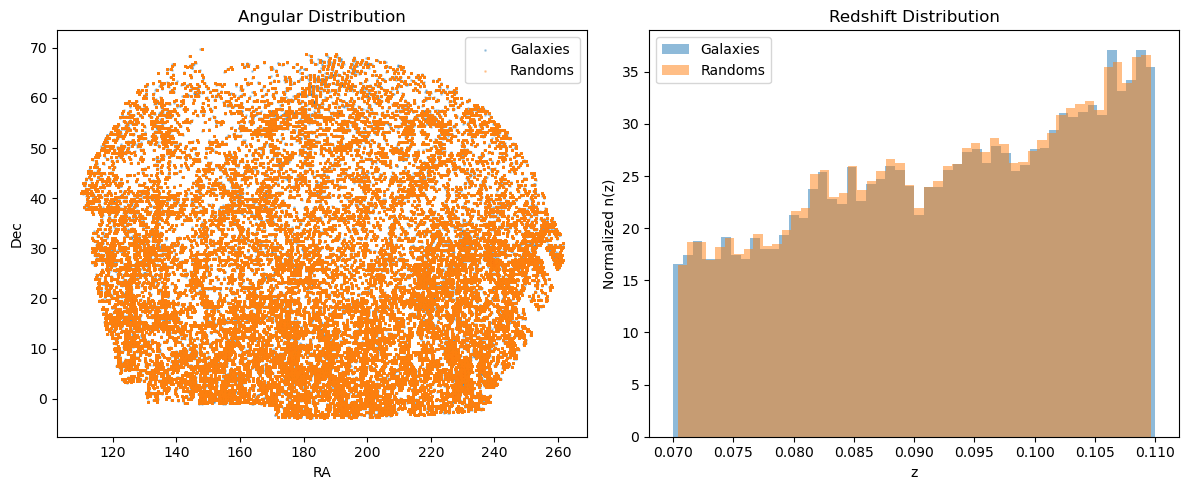

Random catalogue saved.


In [16]:
"""
BAO-safe random catalogue generator

- Angular selection from footprint mask only
- Radial selection from smooth n(z) fit
- Generates RA, Dec, z random catalogue
- Includes diagnostic plots
"""

import numpy as np
import healpy as hp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid
from astropy.cosmology import FlatLambdaCDM

# ------------------------------------------------------------
# Cosmology (adjust if needed)
# ------------------------------------------------------------
h = 0.6774
cosmo = FlatLambdaCDM(H0=100*h, Om0=0.3089)

# ------------------------------------------------------------
# 1. Load galaxy catalogue
# ------------------------------------------------------------
cat = pd.read_csv("../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv")

zmin, zmax = 0.07, 0.11
mag_max = -21.0

cat = cat[(cat["red"] >= zmin) & (cat["red"] <= zmax)]
cat = cat[cat["mag_abs_r"] - 5*np.log10(h) < mag_max]

ra_gal  = cat["ra"].values
dec_gal = cat["dec"].values
z_gal   = cat["red"].values

print(f"N galaxies = {len(z_gal)}")

# ------------------------------------------------------------
# 2. Build angular footprint mask (no smoothing!)
# ------------------------------------------------------------
nside = 128
npix = hp.nside2npix(nside)

theta = np.radians(90 - dec_gal)
phi   = np.radians(ra_gal)

pixels = hp.ang2pix(nside, theta, phi)

mask = np.zeros(npix)
mask[pixels] = 1  # footprint only

good_pixels = np.where(mask > 0)[0]

# ------------------------------------------------------------
# 3. Generate uniform angular randoms inside footprint
# ------------------------------------------------------------
Nrand = 20 * len(z_gal)

chosen_pix = np.random.choice(good_pixels, size=Nrand)

theta_rand, phi_rand = hp.pix2ang(nside, chosen_pix)

ra_rand  = np.degrees(phi_rand)
dec_rand = 90 - np.degrees(theta_rand)

# ------------------------------------------------------------
# 4. Fit smooth n(z) and generate random redshifts
# ------------------------------------------------------------
nbins = 50
hist, bin_edges = np.histogram(z_gal, bins=nbins, range=(zmin, zmax))
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Smooth with interpolation
nz_interp = interp1d(bin_centers, hist, kind='cubic', fill_value=0, bounds_error=False)

z_grid = np.linspace(zmin, zmax, 1000)
nz_smooth = nz_interp(z_grid)
nz_smooth[nz_smooth < 0] = 0

# Build CDF
cdf = cumulative_trapezoid(nz_smooth, z_grid, initial=0)
cdf /= cdf[-1]

# Inverse CDF sampling
inv_cdf = interp1d(cdf, z_grid)

u = np.random.uniform(0, 1, Nrand)
z_rand = inv_cdf(u)

# ------------------------------------------------------------
# 5. Convert to comoving distance (for TreeCorr etc.)
# ------------------------------------------------------------
r_rand = cosmo.comoving_distance(z_rand).value  # in Mpc

# ------------------------------------------------------------
# 6. Diagnostic Plots
# ------------------------------------------------------------
plt.figure(figsize=(12,5))

# Angular comparison
plt.subplot(1,2,1)
plt.scatter(ra_gal, dec_gal, s=1, alpha=0.3, label="Galaxies")
plt.scatter(ra_rand, dec_rand, s=1, alpha=0.3, label="Randoms")
plt.xlabel("RA")
plt.ylabel("Dec")
plt.legend()
plt.title("Angular Distribution")

# Redshift comparison
plt.subplot(1,2,2)
plt.hist(z_gal, bins=nbins, density=True, alpha=0.5, label="Galaxies")
plt.hist(z_rand, bins=nbins, density=True, alpha=0.5, label="Randoms")
plt.xlabel("z")
plt.ylabel("Normalized n(z)")
plt.legend()
plt.title("Redshift Distribution")

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 7. Save random catalogue
# ------------------------------------------------------------
rand_cat = pd.DataFrame({
    "ra": ra_rand,
    "dec": dec_rand,
    "z": z_rand,
    "r_comoving": r_rand
})

#rand_cat.to_csv("random_catalogue_bao_safe.csv", index=False)

print("Random catalogue saved.")

N galaxies: 23138
Sky fraction: 0.036275227864583336


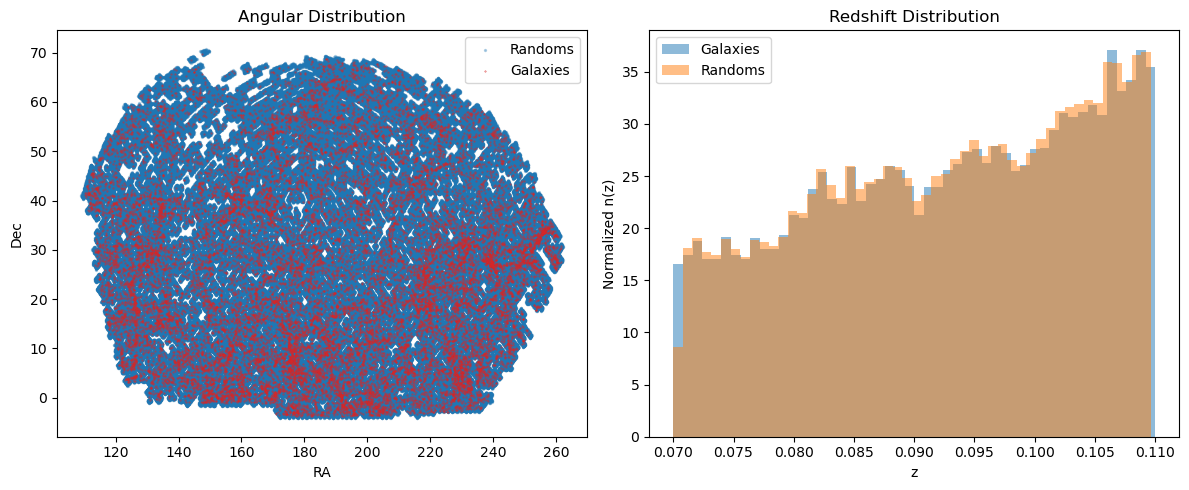

Random catalogue generated successfully.


In [39]:
"""
BAO-safe random catalogue generator (clean version)

- Applies magnitude and redshift cuts
- Builds binary footprint mask
- Smooths footprint only
- Generates uniform angular randoms
- Generates smooth n(z)
"""

import numpy as np
import healpy as hp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid
from astropy.cosmology import FlatLambdaCDM

# ============================================================
# 1. Cosmology
# ============================================================

h = 0.6774
cosmo = FlatLambdaCDM(H0=100*h, Om0=0.3089)

# ============================================================
# 2. Load and Cut Galaxy Catalogue
# ============================================================

cat = pd.read_csv("../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv")

zmin, zmax = 0.07, 0.11
mag_max = -21.0

cat = cat[(cat["red"] >= zmin) & (cat["red"] <= zmax)]
cat = cat[cat["mag_abs_r"] - 5*np.log10(h) < mag_max].copy()

ra_gal  = cat["ra"].values
dec_gal = cat["dec"].values
z_gal   = cat["red"].values

print("N galaxies:", len(z_gal))

# ============================================================
# 3. Build Binary Footprint Mask
# ============================================================

nside = 64
pixels = hp.ang2pix(nside, ra_gal, dec_gal, lonlat=True)
counts = np.bincount(pixels, minlength=hp.nside2npix(nside))
mask = counts > 0



# ============================================================
# 4. Smooth Footprint (NOT density!)
# ============================================================

mask = mask.astype(float)
mask_smooth = hp.smoothing(mask, fwhm=np.deg2rad(1.0))
mask_final = mask_smooth > 0.2

# Renormalize
mask_smooth -= mask_smooth.min()
mask_smooth /= mask_smooth.max()

# Hard threshold
threshold = 0.01
mask_smooth -= mask_smooth.min()
mask_smooth /= mask_smooth.max()

mask_smooth *= mask   # 🔥 enforce original footprint support

threshold = 0.01
mask_final = mask_smooth > threshold

good_pixels = np.where(mask_final)[0]

print("Sky fraction:", len(good_pixels) / npix)

# ============================================================
# 5. Generate Uniform Angular Randoms (no pixel-centers!)
# ============================================================

Nrand = 20 * len(z_gal)

ra_rand = []
dec_rand = []

while len(ra_rand) < Nrand:
    
    # Generate full-sky uniform points
    ra_try  = np.random.uniform(0, 360, Nrand)
    u       = np.random.uniform(-1, 1, Nrand)
    dec_try = np.degrees(np.arcsin(u))
    
    pix_try = hp.ang2pix(nside, ra_try, dec_try, lonlat=True)
    
    keep = mask_final[pix_try]
    
    ra_rand.extend(ra_try[keep])
    dec_rand.extend(dec_try[keep])

ra_rand  = np.array(ra_rand[:Nrand])
dec_rand = np.array(dec_rand[:Nrand])

# ============================================================
# 6. Smooth n(z) and Sample Redshifts
# ============================================================

nbins = 50
hist, bin_edges = np.histogram(z_gal, bins=nbins, range=(zmin, zmax))
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

nz_interp = interp1d(bin_centers, hist, kind='cubic',
                     bounds_error=False, fill_value=0)

z_grid = np.linspace(zmin, zmax, 2000)
nz_smooth = nz_interp(z_grid)
nz_smooth[nz_smooth < 0] = 0

cdf = cumulative_trapezoid(nz_smooth, z_grid, initial=0)
cdf /= cdf[-1]

cdf_unique, idx = np.unique(cdf, return_index=True)
inv_cdf = interp1d(cdf_unique, z_grid[idx],
                   bounds_error=False,
                   fill_value=(zmin, zmax))

u = np.random.uniform(0, 1, Nrand)
z_rand = inv_cdf(u)

# ============================================================
# 7. Convert to Comoving Distance
# ============================================================

r_rand = cosmo.comoving_distance(z_rand).value  # Mpc

# ============================================================
# 8. Diagnostics
# ============================================================

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(ra_rand, dec_rand, s=2, alpha=0.3, label="Randoms")

plt.scatter(ra_gal, dec_gal, s=.1, alpha=1, label="Galaxies", c='C03')
plt.xlabel("RA")
plt.ylabel("Dec")
plt.legend()
plt.title("Angular Distribution")

plt.subplot(1,2,2)
plt.hist(z_gal, bins=nbins, density=True, alpha=0.5, label="Galaxies")
plt.hist(z_rand, bins=nbins, density=True, alpha=0.5, label="Randoms")
plt.xlabel("z")
plt.ylabel("Normalized n(z)")
plt.legend()
plt.title("Redshift Distribution")

plt.tight_layout()
plt.show()

# ============================================================
# 9. Save
# ============================================================

rand_cat = pd.DataFrame({
    "ra": ra_rand,
    "dec": dec_rand,
    "z": z_rand,
    "r_comoving": r_rand
})

# rand_cat.to_csv("random_catalogue_bao_safe.csv", index=False)

print("Random catalogue generated successfully.")
